# KnockoffScreen knockoffs


!!! warning

    KnockoffScreen Knockoffs are provided as experimental feature. 

This is a tutorial for generating KnockoffScreen knockoffs for [genome-wide association studies](https://en.wikipedia.org/wiki/Genome-wide_association_study). This kind of knockoffs is designed for sequence data that have a lot of rare variants. The methodology is described in the following papers

> He, Zihuai, Linxi Liu, Chen Wang, Yann Le Guen, Justin Lee, Stephanie Gogarten, Fred Lu et al. "Identification of putative causal loci in whole-genome sequencing data via knockoff statistics." Nature communications 12, no. 1 (2021): 1-18.

> He, Zihuai, Yann Le Guen, Linxi Liu, Justin Lee, Shiyang Ma, Andrew C. Yang, Xiaoxia Liu et al. "Genome-wide analysis of common and rare variants via multiple knockoffs at biobank scale, with an application to Alzheimer disease genetics." The American Journal of Human Genetics 108, no. 12 (2021): 2336-2353

In particular, we generate:

```math
\begin{align*}
\hat{X}_j &= \hat{\beta_0} + \sum_{k \in B_j}\hat{\beta_k}X_k + \sum_{k \in B_j, k \le j - 1}\hat{\gamma_k}\tilde{X_k}\\
\hat{\epsilon} &= permute(X_j - \hat{X}_j)\\
\tilde{X}_j &= \hat{X}_j + \hat{\epsilon}
\end{align*}
```

where $B_j$ is a ball of variants near $j$ and $\hat{\beta}_k, \hat{\gamma}_k$ are estimated via least squares. 

In [2]:
# first load packages needed for this tutorial
using SnpArrays
using Knockoffs
using Statistics
using Plots
using GLMNet
using Distributions
using Random
gr(fmt=:png);

## Step 0: Prepare example data

To illustrate we need example PLINK data, which are available in `Knockoffs/data/mouse.imputed.(bed/bim/fam)`

In [3]:
# Path to PLINK data
mouse_path = joinpath(normpath(Knockoffs.datadir()), "mouse.imputed")

"/Users/biona001/.julia/dev/Knockoffs/data/mouse.imputed"

## Step 1: Generate Knockoffs

Knockoffs are made using the wrapper function [full_knockoffscreen](https://biona001.github.io/Knockoffs.jl/dev/man/api/#Knockoffs.full_knockoffscreen). An iterator format that streams knockoffs one by one is coming soon.

!!! warning

    The output of `full_knockoffscreen` is a dense `Float64` matrix, which requires $8np$ bytes of RAM. Do not call it on large PLINK files. 

In [3]:
@time X̃ = full_knockoffscreen(mouse_path, windowsize=50)

Generating knockoffs100%|███████████████████████████████| Time: 0:01:40


129.793232 seconds (74.18 M allocations: 34.660 GiB, 5.35% gc time, 23.10% compilation time)


1940×10150 Matrix{Float64}:
 -0.158027  -0.15993  -0.397849  …   0.663515   0.664671   0.668258
 -0.157256  -0.15993   1.07455       0.663515   0.664671   0.666508
  1.26416    1.2633    0.914503      0.663515   0.664671   0.669306
 -0.158079  -0.15993  -0.412851      0.663515   0.664671   0.667707
  1.2641     1.2633    1.05954      -1.17537   -1.17217   -1.16703
 -0.15979   -0.15993  -0.412641  …   0.663515   0.664671   0.66629
 -0.159042  -0.15993   0.258318      0.663515   0.664671   0.669239
 -0.158219  -0.15993   1.0255        0.663515   0.664671   0.665875
 -0.156292  -0.15993   1.07454       0.663515   0.664671   0.667836
  1.26493    1.2633    1.07325      -1.17537   -1.17217   -1.16801
  1.26685    1.2633    0.258326  …  -3.01425   -3.00901   -3.00042
 -0.157256  -0.15993  -0.397863      0.663515   0.664671   0.669154
  1.26332    1.2633    1.06682      -3.01425   -3.00901   -3.00326
  ⋮                              ⋱                        
  1.26412    1.2633    1.0803     

## Step 2: Examine knockoff statistics

Lets check if the knockoffs "make sense". For example, we can compare SNP 1 and its knockoff (which are very similar):

In [5]:
# import original genotypes into numeric matrix
X = convert(Matrix{Float64}, SnpArray(mouse_path * ".bed"), center=true, scale=true)

# compare SNP 1 with its knockoff
[X[:, 1] X̃[:, 1]]

1940×2 Matrix{Float64}:
 -0.159187  -0.157256
 -0.159187  -0.158219
  1.26396    1.26388
 -0.159187  -0.158219
  1.26396    1.26589
 -0.159187  -0.158219
 -0.159187  -0.159424
 -0.159187  -0.157256
 -0.159187  -0.158219
  1.26396    1.2641
  1.26396    1.26685
 -0.159187  -0.158986
  1.26396    1.26589
  ⋮         
  1.26396    1.26589
  1.26396    1.2641
 -0.159187  -0.160036
 -0.159187  -0.157256
  1.26396    1.26589
 -0.159187  -0.159753
  1.26396    1.26589
 -0.159187  -0.158219
 -0.159187  -0.159005
 -0.159187  -0.15899
 -0.159187  -0.158219
 -1.58233   -1.58241

Lets also compare $cor(X_i, X_j)$ and $cor(X_i, \tilde{X}_j)$. If knockoffs satisfy exchangability, their correlation should be very similar and form a diagonal line. 

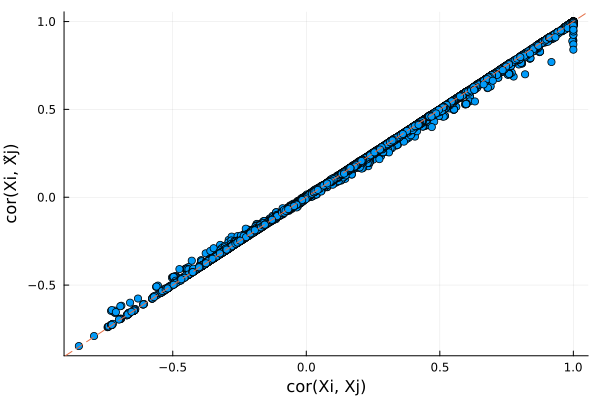

In [6]:
# look at pairwise correlation (between first 200 snps)
r1, r2 = Float64[], Float64[]
for i in 1:200, j in 1:i
    push!(r1, cor(@view(X[:, i]), @view(X[:, j])))
    push!(r2, cor(@view(X[:, i]), @view(X̃[:, j])))
end

# make plot
scatter(r1, r2, xlabel = "cor(Xi, Xj)", ylabel="cor(Xi, X̃j)", legend=false)
Plots.abline!(1, 0, line=:dash)

Plots distribution of $cor(X_j, \tilde{X}_j)$ for all $j$. Ideally, we want $cor(X_j, \tilde{X}_j)$ to be small in magnitude (i.e. $X$ and $\tilde{X}$ is very different). Here the knockoffs are tightly correlated with the original genotypes, so they will likely have low power. 

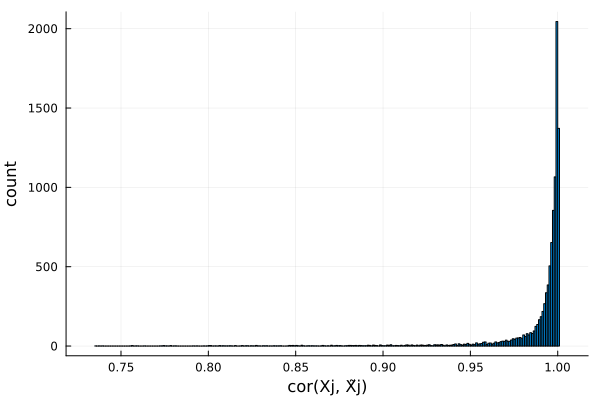

In [7]:
r2 = Float64[]
for j in 1:size(X, 2)
    push!(r1, cor(@view(X[:, j]), @view(X[:, j])))
    push!(r2, cor(@view(X[:, j]), @view(X̃[:, j])))
end
histogram(r2, legend=false, xlabel="cor(Xj, X̃j)", ylabel="count")